# Regression problem

The task is to predict the median price of a house on a given district in California, given past records on sold properties in this US state.

Make sure scikit-optimize is installed:

In [1]:
!pip install scikit-optimize

In [2]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

sns.set_theme(palette="Set2")

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# increase column width
pd.set_option('display.max_colwidth', 100)

# Load the data

Use the output of the data cleaning step.

In [3]:
trainset = pd.read_csv("trainset-ca-housing.csv")
testset = pd.read_csv("testset-ca-housing.csv")

Create separate arrays for the predictors (`Xtrain` and `Xtest`) and for the target (`ytrain` and `ytest`):

In [4]:
Xtrain = trainset.drop("median_house_value", axis=1)
ytrain = trainset["median_house_value"].copy()
Xtest = testset.drop("median_house_value", axis=1)
ytest = testset["median_house_value"].copy()

In [5]:
Xtrain.shape, Xtest.shape

((15262, 10), (3819, 10))

# Baseline

We'll use a simple baseline: for all test instances, predict the median value seen in the training data:

In [6]:
median_price = ytrain.median()
median_price

174200.0

In [7]:
from sklearn.metrics import mean_squared_error

# each value in yhat will be the same value, median_price
yhat = np.full((ytrain.shape[0], 1), median_price)
yhat[:10]

array([[174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.]])

In [8]:
baseline_training_mse = mean_squared_error(ytrain, yhat)
baseline_training_mse = np.sqrt(baseline_training_mse)
baseline_training_mse

98893.41775622815

In [9]:
yhat = np.full((ytest.shape[0], 1), median_price)

baseline_test_mse = mean_squared_error(ytest, yhat)
baseline_test_mse = np.sqrt(baseline_test_mse)
baseline_test_mse

99712.47039692692

# Model development

## Evaluating on training set

### Linear regression

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)

LinearRegression()

In [11]:
# make predictions
yhat = lin_reg.predict(Xtrain)

lin_mse = mean_squared_error(ytrain, yhat)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

64486.45030851371

<Axes: >

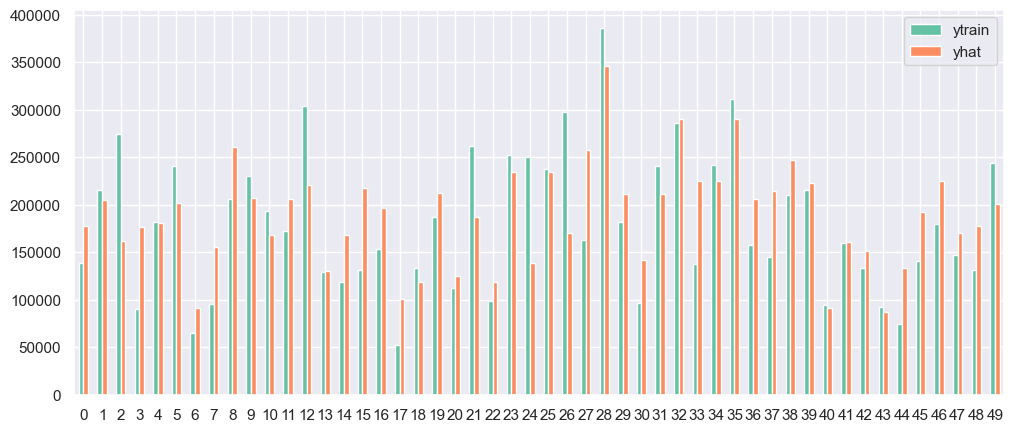

In [12]:
# depict the predictions

# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[:50], "yhat": yhat[:50]})
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

### Decision Trees

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=7)
tree_reg.fit(Xtrain, ytrain)
yhat = tree_reg.predict(Xtrain)
tree_mse = mean_squared_error(ytrain, yhat)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

<Axes: >

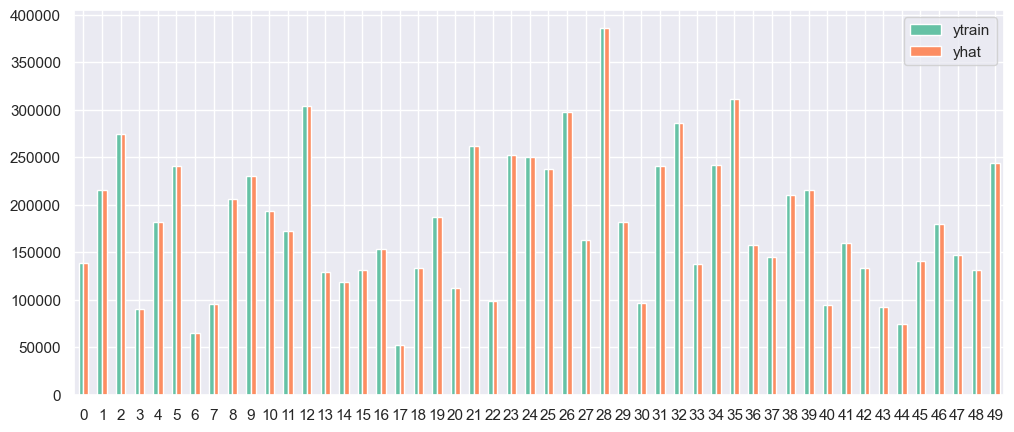

In [14]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [15]:
# the total number of leaves of the tree
tree_reg.get_n_leaves()

15127

In [16]:
# the depth of the tree
tree_reg.get_depth()

33

## Cross-validation

In [17]:
from sklearn.model_selection import cross_val_score

### Linear regression

In [18]:
lin_reg = LinearRegression()
rmse_scores = -cross_val_score(lin_reg, Xtrain, ytrain,
                               scoring="neg_root_mean_squared_error", cv=10)

In [19]:
rmse_scores

array([62719.91884871, 65497.0888686 , 65951.71962091, 64629.61541717,
       63375.3970824 , 64682.02350943, 66427.00509713, 63798.16956274,
       64288.67591419, 64125.53506529])

In [20]:
rmse_scores.mean()

64549.514898656926

In [21]:
rmse_scores.std()

1093.220408844004

### Decision Trees

In [22]:
tree_reg = DecisionTreeRegressor(random_state=7)

rmse_scores = -cross_val_score(tree_reg, Xtrain, ytrain, 
                               scoring="neg_root_mean_squared_error",
                               cv=10)

In [23]:
rmse_scores.mean()

74858.95417057848

In [24]:
rmse_scores.std()

1475.2544895402661

## Tuning hyperparameters

In [25]:
tree_reg = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=10000,
                                 random_state=7)

rmse_scores = -cross_val_score(tree_reg, Xtrain, ytrain, 
                               scoring="neg_root_mean_squared_error", 
                               cv=10)

In [26]:
rmse_scores.mean()

64104.78857434927

In [27]:
rmse_scores.std()

836.3835027016793

### Exhaustive grid search

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
start = timer()

# specify the hyperparameters and their values
hp_grid = {
    'max_depth': [2, 10, 15, 20, 25],
    'min_samples_leaf': [1, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20, 30, 40, 50],
    'max_leaf_nodes': [5000, 10000, None]
}

tree_reg = DecisionTreeRegressor(random_state=7)

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(tree_reg, hp_grid, cv=10,
                           scoring='neg_root_mean_squared_error', 
                           return_train_score=True, verbose=2)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=5000, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END

In [30]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=15, max_leaf_nodes=5000, min_samples_leaf=30,
                      random_state=7)

In [31]:
-grid_search.best_score_

60859.95864793115

In [32]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
307,"{'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 30, 'min_samples_split': 10}",53644.666217,60859.958648,-13.450158
236,"{'max_depth': 15, 'max_leaf_nodes': 5000, 'min_samples_leaf': 30, 'min_samples_split': 20}",53644.666217,60859.958648,-13.450158
237,"{'max_depth': 15, 'max_leaf_nodes': 5000, 'min_samples_leaf': 30, 'min_samples_split': 30}",53644.666217,60859.958648,-13.450158
238,"{'max_depth': 15, 'max_leaf_nodes': 5000, 'min_samples_leaf': 30, 'min_samples_split': 40}",53644.666217,60859.958648,-13.450158
239,"{'max_depth': 15, 'max_leaf_nodes': 5000, 'min_samples_leaf': 30, 'min_samples_split': 50}",53644.666217,60859.958648,-13.450158
...,...,...,...,...
73,"{'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 10}",75879.468806,76077.984255,-0.261619
74,"{'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 20}",75879.468806,76077.984255,-0.261619
75,"{'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 30}",75879.468806,76077.984255,-0.261619
62,"{'max_depth': 2, 'max_leaf_nodes': 10000, 'min_samples_leaf': 40, 'min_samples_split': 20}",75879.468806,76077.984255,-0.261619


### Randomized grid search

When the search space of hyperparameters is very large, running exhaustive grid search may take too much time. In such cases, one can try `RandomizedSearchCV` instead. It allows to limit the number of models to build and thus control the amount of computing resources one uses.

The class works very much the same as `GridSearchCV`, but takes extra arguments: `n_iter`, the number of random combinations to try and `random_state`, which can be set to the same constant to ensure that the same random combinations are tried in different runs of the code.

Here, we will try 30 random combinations (`n_iter=30`), instead of an exhaustive search with all possible value combinations.

In [33]:
from sklearn.model_selection import RandomizedSearchCV

In [34]:
start = timer()

# specify the hyperparameters and their values
hp_grid = {
    'max_depth': [2, 10, 15, 20, 25],
    'min_samples_leaf': [1, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20, 30, 40, 50],
    'max_leaf_nodes': [5000, 10000, None]
}

tree_reg = DecisionTreeRegressor(random_state=7)

# we'll use 10-fold cross-validation
rand_grid_search = RandomizedSearchCV(tree_reg, hp_grid, cv=10, n_iter=30,
                                     scoring='neg_root_mean_squared_error', random_state=7,
                                     return_train_score=True, verbose=2)

rand_grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.0s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_spl

In [35]:
rand_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=15, max_leaf_nodes=10000, min_samples_leaf=30,
                      random_state=7)

Its RMSE score is:

In [36]:
-rand_grid_search.best_score_

60859.95864793115

In [37]:
cv_results = pd.DataFrame(rand_grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
7,"{'min_samples_split': 2, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 15}",53644.666217,60859.958648,-13.450158
8,"{'min_samples_split': 20, 'min_samples_leaf': 30, 'max_leaf_nodes': None, 'max_depth': 15}",53644.666217,60859.958648,-13.450158
25,"{'min_samples_split': 40, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 25}",53640.278269,60861.733304,-13.462747
21,"{'min_samples_split': 40, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 20}",53640.278269,60861.733304,-13.462747
10,"{'min_samples_split': 50, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_depth': 25}",51628.597029,60870.181156,-17.900126
0,"{'min_samples_split': 40, 'min_samples_leaf': 20, 'max_leaf_nodes': 10000, 'max_depth': 25}",50825.059143,60985.699124,-19.991398
17,"{'min_samples_split': 2, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_depth': 20}",50825.059143,60986.657101,-19.993283
1,"{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_depth': 10}",53323.860034,61179.001744,-14.731007
15,"{'min_samples_split': 50, 'min_samples_leaf': 10, 'max_leaf_nodes': 10000, 'max_depth': 10}",52887.589693,61179.686781,-15.678720
13,"{'min_samples_split': 30, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 10}",55032.706487,61220.942527,-11.244651


### Bayesian Optimisation

In [38]:
from skopt import BayesSearchCV

In [39]:
start = timer()

hp_grid = {
         'max_depth': [2, 25],
         'min_samples_leaf': [1, 50],
         'min_samples_split': [2, 50],
         'max_leaf_nodes': [5000, 16000]     
     }

opt_grid_search = BayesSearchCV(
     DecisionTreeRegressor(random_state=7),
     hp_grid,
     n_iter=30,
     random_state=7,
     scoring='neg_root_mean_squared_error',
     return_train_score=True,
     cv=10
)

np.int = int
opt_grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:01:02.118327


In [40]:
opt_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=21, max_leaf_nodes=14950, min_samples_leaf=27,
                      min_samples_split=49, random_state=7)

In [41]:
-opt_grid_search.best_score_

60964.22309621625

In [42]:
cv_results = pd.DataFrame(opt_grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
14,"{'max_depth': 23, 'max_leaf_nodes': 14848, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
27,"{'max_depth': 23, 'max_leaf_nodes': 14464, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
26,"{'max_depth': 23, 'max_leaf_nodes': 14465, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
25,"{'max_depth': 23, 'max_leaf_nodes': 14472, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
23,"{'max_depth': 23, 'max_leaf_nodes': 14855, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
22,"{'max_depth': 23, 'max_leaf_nodes': 14845, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
21,"{'max_depth': 23, 'max_leaf_nodes': 14997, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
20,"{'max_depth': 23, 'max_leaf_nodes': 14817, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
19,"{'max_depth': 23, 'max_leaf_nodes': 14936, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996
18,"{'max_depth': 23, 'max_leaf_nodes': 14805, 'min_samples_leaf': 27, 'min_samples_split': 48}",52927.226089,60964.223096,-15.184996


# Evaluate on the test set

In [43]:
best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_mse = mean_squared_error(ytest, yhat)
final_rmse = np.sqrt(final_mse)
final_rmse

60020.35053244312

<Axes: >

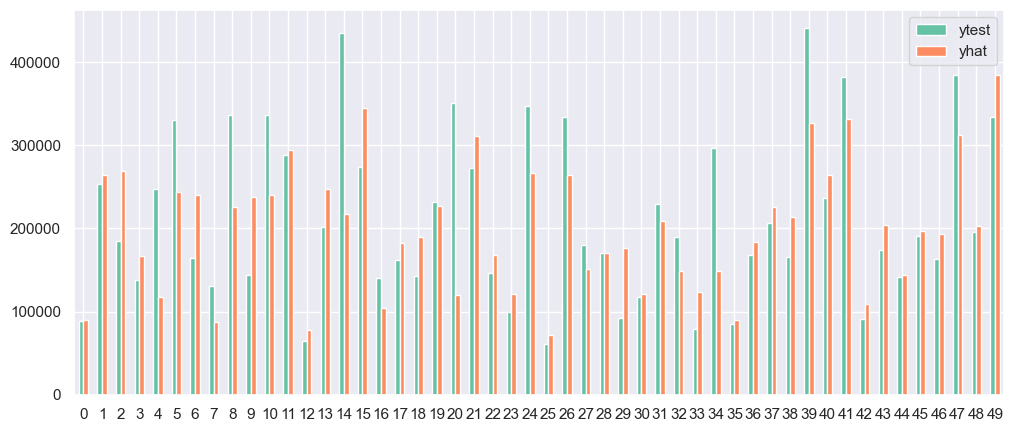

In [44]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytest": ytest[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

## Analyze important predictors

### Gini importances

In [45]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k:.3f}")

median_income: 0.624
longitude: 0.137
rooms_per_household: 0.084
housing_median_age: 0.065
ocean_proximity_NEAR OCEAN: 0.030
total_bedrooms: 0.026
population: 0.018
total_rooms: 0.007
ocean_proximity_NEAR BAY: 0.006
households: 0.005


### Permutation importances

In [46]:
from sklearn.inspection import permutation_importance

result = permutation_importance(grid_search.best_estimator_, Xtest, ytest, 
                                n_repeats=10, random_state=7, 
                                scoring='neg_root_mean_squared_error')

In [47]:
# raw permutation importance scores
sorted_importances_idx = result.importances_mean.argsort()
raw_importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=Xtrain.columns[sorted_importances_idx],
)
raw_importances

,ocean_proximity_NEAR BAY,total_rooms,households,population,total_bedrooms,ocean_proximity_NEAR OCEAN,housing_median_age,rooms_per_household,longitude,median_income
0,420.320049,448.183453,811.354520,2504.314304,4543.411341,6189.777080,6525.221546,7172.908188,15584.833399,57220.903745
1,478.413800,538.991218,627.075878,2531.607378,5035.223156,6159.825203,7550.854963,6924.512244,14996.241365,58371.505055
2,480.866296,549.206778,769.163712,2019.892401,5092.896507,6789.826545,7702.898838,7436.518506,14518.718935,57433.818004
3,541.844745,872.434519,612.195975,2198.320076,5588.842330,6080.005476,6604.224840,7611.712744,15002.339471,58863.170784
4,763.383313,444.175988,721.561572,2196.593354,4921.513024,6418.675591,7704.983918,7734.751865,15972.757562,56876.234190
5,478.139693,458.343007,810.154236,2027.026177,4879.780546,6180.423442,6199.867441,6892.442356,14647.556202,58172.201766
6,399.063037,477.977104,718.065915,2360.647518,5763.268712,6713.658239,6728.443495,7267.831416,14470.566351,57656.016320
7,546.491163,415.234933,466.496407,2125.566428,4882.351862,6470.750446,6860.028305,6960.007947,15050.481036,58238.240107
8,395.338309,723.014476,528.584647,2049.627688,6134.988778,6014.411408,6717.346040,7262.325446,15615.150298,58903.005908
9,510.674618,454.623814,910.503556,2430.750449,4962.722103,6384.170544,6737.863084,7421.171379,15500.587759,58662.876779


In [48]:
result.importances_mean

array([15135.92323781,  6933.17324717,   538.21852903,  5180.49983603,
        2244.4345775 ,   697.51564169, 58039.79726563,  7268.41820902,
         501.45350236,  6340.15239746])

In [49]:
Xtest.columns

Index(['longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'median_income', 'rooms_per_household',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [50]:
pd.Series(result.importances_mean, index=Xtest.columns).sort_values(ascending=False)

median_income                 58039.797266
longitude                     15135.923238
rooms_per_household            7268.418209
housing_median_age             6933.173247
ocean_proximity_NEAR OCEAN     6340.152397
total_bedrooms                 5180.499836
population                     2244.434578
households                      697.515642
total_rooms                     538.218529
ocean_proximity_NEAR BAY        501.453502
dtype: float64

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm